In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set(font_scale=1.5)
sns.set_theme(style="ticks", font_scale=1.5)

import pandas as pd
import iceutils as ice

In [2]:
# Load samples
x_mcmc, all_samples_mcmc = ice.h5read('samples_mcmc.h5', ('x', 'theta_samples'))
x_vgp, all_samples_vgp = ice.h5read('samples_vgp.h5', ('x', 'theta_samples'))

mean_mcmc = np.mean(all_samples_mcmc, axis=0)
std_mcmc = 2*np.std(all_samples_mcmc, axis=0)

mean_vgp = np.mean(all_samples_vgp, axis=0)
std_vgp = 2*np.std(all_samples_vgp, axis=0)

sub = 2
all_samples_mcmc = all_samples_mcmc[::sub]
all_samples_vgp = all_samples_vgp[::sub]

#all_samples_mcmc += 0.2

In [3]:
# Extract samples for specific points of interest
#x_vals = [60, 80, 85, 95]
#x_vals = [50, 80, 85, 95]
x_vals = [55, 75, 85, 95]

data = {}
for i, x in enumerate(x_vals):
    
    ind = np.argmin(np.abs(x_mcmc - 1.0e3*x))
    samples_mcmc = all_samples_mcmc[:, ind]
    
    ind = np.argmin(np.abs(x_vgp - 1.0e3*x))
    samples_vgp = all_samples_vgp[:, ind]
    
    x_upstream = 100 - x
    key = 'X = %d km' % x_upstream
    data[key] = np.hstack((samples_mcmc, samples_vgp))

data['Method'] = ['MCMC'] * all_samples_mcmc.shape[0] + ['VGP'] * all_samples_vgp.shape[0]
    

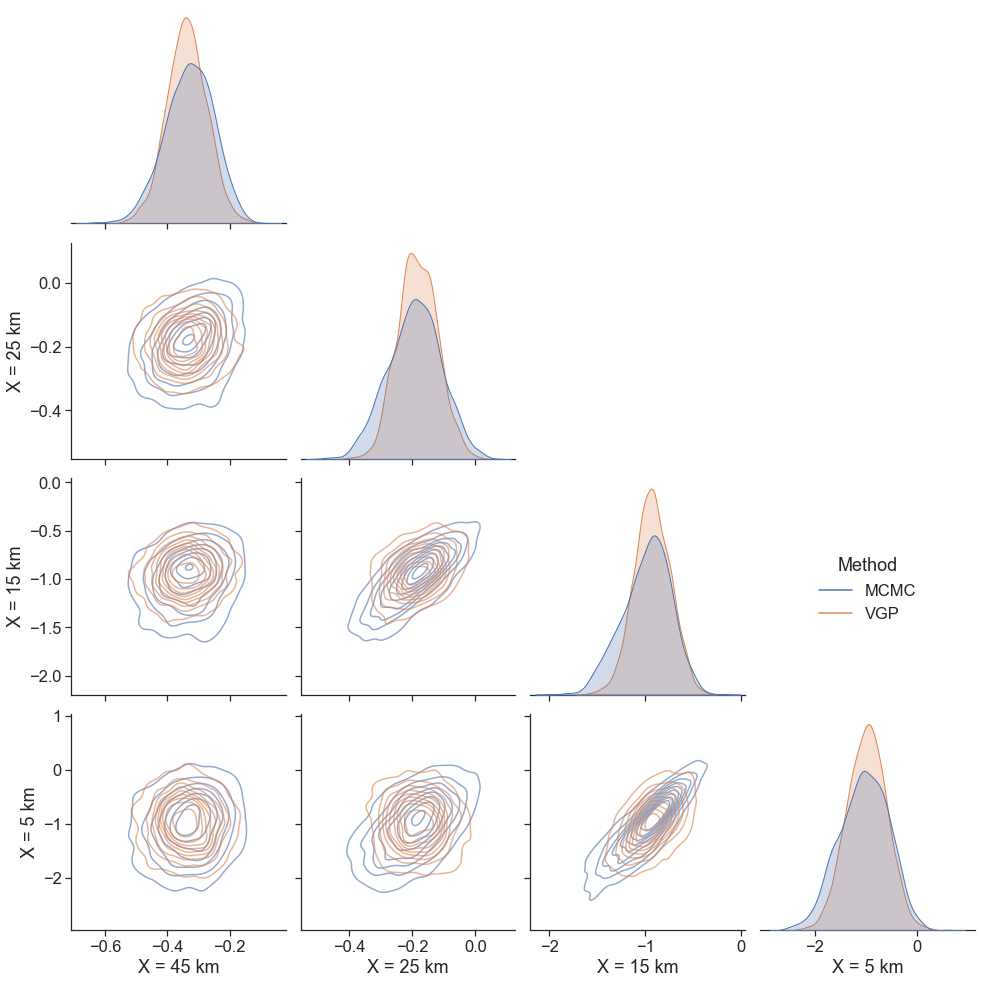

In [4]:
df = pd.DataFrame(data)
pp = sns.pairplot(df, hue='Method',kind='kde', diag_kind='kde', corner=True, height=3.5,
                  plot_kws={'alpha': 0.6})

sns.move_legend(pp, 'upper left', bbox_to_anchor=(0.73, 0.45))

# Set plot_true = True to show true values of theta
plot_true = False
if plot_true:
    x_ref, B_ref = ice.h5read('data_noise.h5', ('x', 'B_ref'))
    for i, x in enumerate(x_vals):
        ax = pp.axes[i, i]
        ind = np.argmin(np.abs(1.0e3*x - x_ref))
        theta = np.log(B_ref[ind]) - np.log(400.0)
        ax.axvline(theta, color='k', ls='--', lw=1)
        
        for j in range(i+1):
            if j == i: continue
            ax = pp.axes[i, j]
            ind_j = np.argmin(np.abs(1.0e3*x_vals[j] - x_ref))
            theta_j = np.log(B_ref[ind_j]) - np.log(400.0)
            ax.plot(theta_j, theta, '*k', ms=10)
        
plt.savefig('figures/pairplot.pdf', bbox_inches='tight', transparent=True)

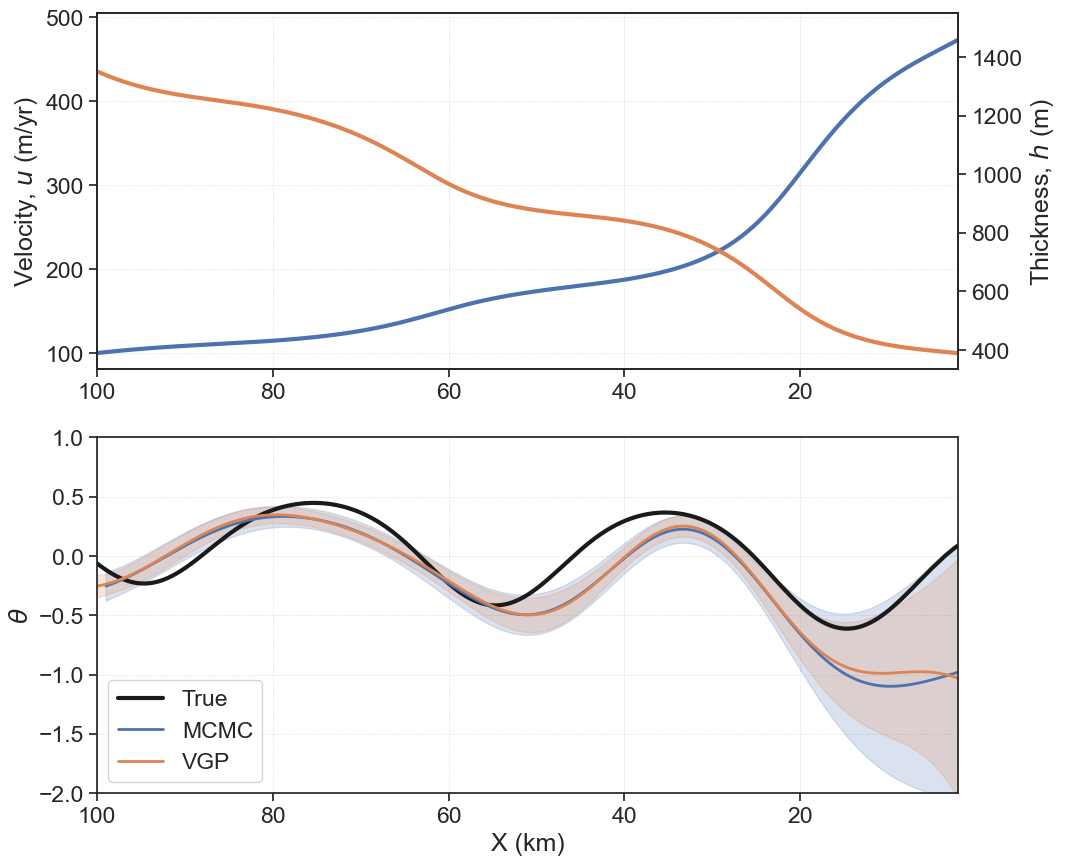

In [5]:
x_ref, u_ref, h_ref, B_ref = ice.h5read('data_noise.h5', ('x', 'u_ref', 'h_ref', 'B_ref'))
theta_ref = np.log(B_ref) - np.log(400.0)

u_x = np.gradient(u_ref, x_ref, edge_order=2)
h_x = np.gradient(h_ref, x_ref, edge_order=2)
s_x = h_x * (1 - 917 / 1024)
td = -1.0e-3 * 917 * 9.81 * h_ref * s_x

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(11, 9))

ax1.plot(100 - 1.0e-3*x_ref, u_ref, lw=3)
ax1b = ax1.twinx()
ax1b.plot(100 - 1.0e-3*x_ref, h_ref, lw=3, color='C1')
ax1b.set_ylim(None, 1550)

ax2.plot(100 - 1.0e-3*x_ref, theta_ref, 'k', lw=3, label='True')

line, = ax2.plot(100 - 1.0e-3*x_mcmc, mean_mcmc, lw=2, label='MCMC')
ax2.fill_between(100 - 1.0e-3*x_mcmc, mean_mcmc - std_mcmc, mean_mcmc + std_mcmc, color=line.get_color(), alpha=0.2)

line, = ax2.plot(100 - 1.0e-3*x_vgp, mean_vgp, lw=2, label='VGP')
ax2.fill_between(100 - 1.0e-3*x_vgp, mean_vgp - std_vgp, mean_vgp + std_vgp, color=line.get_color(), alpha=0.2)

ax1.set_xlim(100, 2)
ax2.set_xlim(100, 2)
ax2.set_ylim(-2.0, 1)

ax1.set_ylabel(r'Velocity, $u$ (m/yr)')
ax1b.set_ylabel('Thickness, $h$ (m)')
ax2.set_xlabel('X (km)')
ax2.set_ylabel(r'$\theta$')
ax1.grid(True, ls=':', lw=0.5)
ax2.grid(True, ls=':', lw=0.5)

leg = ax2.legend(loc='lower left')

plt.tight_layout()
plt.savefig('figures/profile.pdf', bbox_inches='tight', transparent=True)